In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.ensemble import HistGradientBoostingRegressor as hgbr
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score as r2 
import shap, datetime,warnings
warnings.filterwarnings('ignore')

c:\Users\Steven\Desktop\school github repos\svo-directed-practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open the pickle file
df = pickle.load(open('../../data/processed/merged_data_finance.pkl', 'rb'))
df

date ticker  Article Count_cum04_lag01  \
0      2018-01-03 09:30:00    AAL                          4   
1      2018-01-03 09:30:00   ALGT                          0   
2      2018-01-03 09:30:00    ALK                         15   
3      2018-01-03 09:30:00    DAL                          4   
4      2018-01-03 09:30:00   JBLU                          6   
...                    ...    ...                        ...   
337608 2025-05-30 15:45:00    ALK                          0   
337609 2025-05-30 15:45:00    DAL                          3   
337610 2025-05-30 15:45:00   JBLU                          1   
337611 2025-05-30 15:45:00    LUV                          2   
337612 2025-05-30 15:45:00    UAL                          5   

        Article Count_cum16_lag01  Article Count_cum48_lag01  \
0                              24                         84   
1                               0                          2   
2                              26                        188   
3                               8                         24   
4                               9                         17   
...                           ...                        ...   
337608                          3                          9   
337609                         12                         15   
337610                          4                         13   
337611                          3                         11   
337612                         20                         41   

        Article Count_cum96_lag01  Article Count_lag01  Article Count_lag02  \
0                             142                    1                    0   
1                               2                    0                    0   
2                             241                    5                    0   
3                              53                    1                    0   
4                              42                    1                    1   
...                           ...                  ...                  ...   
337608                         31                    0                    0   
337609                         43                    0                    1   
337610                         49                    0                    0   
337611                         30                    1                    1   
337612                        107                    0                    2   

        Article Count_lag04  Article Count_lag16  ...  \
0                         2                    0  ...   
1                         0                    0  ...   
2                         1                    0  ...   
3                         0                    0  ...   
4                         0                    2  ...   
...                     ...                  ...  ...   
337608                    0                    1  ...   
337609                    1                    1  ...   
337610                    0                    0  ...   
337611                    0                    0  ...   
337612                    0                    0  ...   

        v42.8; SCOREDVALUE; fairness_sent_lag26  \
0                                           0.0   
1                                           0.0   
2                                           0.0   
3                                           0.0   
4                                           0.0   
...                                         ...   
337608                                      0.0   
337609                                      0.0   
337610                                      0.0   
337611                                      0.0   
337612                                      0.0   

        v42.9; SCOREDVALUE; loyalty_sent_cum04_lag01  \
0                                           0.000000   
1                                           0.000000   
2                                           0.000000   
3            

In [4]:
# Data preprocessing
#tickers     = ['AAL','ALGT','ALK','DAL','JBLU','LUV','UAL']
#tickers_all = ['AAL','ALGT','ALK','DAL','JBLU','LUV','UAL','BNO','IYT','ITA','JETS']

y_cols = ['Volume']

#x_cols = [i for i in df.columns if 'lag' in i and all(j not in i for j in ['BNO', 'JETS', 'IYT', 'ITA'])] + [
#'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10',#'month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8',#'month_of_year_9'] + [i for i in df.columns if 'pca' in i]

#x_cols = [i for i in df.columns if 'pca' in i] + [i for i in df.columns if any(j in i for j in ['Tone', 'Article Count'])]

#x_cols = [i for i in df.columns if 'lag' in i and all(j not in i for j in ['JETS', 'IYT', 'ITA', 'pca', 'Tone', 'Article Count'])] + [
#'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10',#'month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8',#'month_of_year_9']

x_cols = [i for i in df.columns if 'lag' in i] + [
'hour_of_day_10','hour_of_day_11','hour_of_day_12','hour_of_day_13','hour_of_day_14','hour_of_day_15','hour_of_day_9','is_close','is_open','month_of_year_1','month_of_year_10','month_of_year_11','month_of_year_12','month_of_year_2','month_of_year_3','month_of_year_4','month_of_year_5','month_of_year_6','month_of_year_7','month_of_year_8','month_of_year_9']

y = df[y_cols]
x = df[x_cols]

In [5]:
# Train/test splitting
split_val  = round(0.8 * len(x))
split_test = round(0.9 * len(x))

x_train = x[:split_val]
x_val   = x[split_val:split_test]
x_test  = x[split_test:]

y_train = y[:split_val]
y_val   = y[split_val:split_test]
y_test  = y[split_test:]

In [6]:
df['date'][:split_val].describe()

count                           270090
mean     2020-12-18 19:03:32.252581888
min                2018-01-03 09:30:00
25%                2019-06-27 12:00:00
50%                2020-12-17 11:30:00
75%                2022-06-10 11:30:00
max                2023-12-04 13:45:00
Name: date, dtype: object

In [7]:
df['date'][split_val:split_test].describe()

count                            33762
mean     2024-04-18 17:40:18.633374464
min                2023-12-04 14:00:00
25%                2024-02-12 10:00:00
50%                2024-04-18 12:30:00
75%                2024-06-25 14:45:00
max                2024-08-30 13:30:00
Name: date, dtype: object

In [8]:
df['date'][split_test:].describe()

count                            33761
mean     2025-01-15 05:11:45.583365120
min                2024-08-30 13:30:00
25%                2024-11-06 09:30:00
50%                2025-01-16 11:00:00
75%                2025-03-25 13:30:00
max                2025-05-30 15:45:00
Name: date, dtype: object

In [9]:
# Normalize the features to [0,1]
sc2 = MinMaxScaler(feature_range=(0, 1))

x_train = sc2.fit_transform(x_train)
x_val   = sc2.transform(x_val)
x_test  = sc2.transform(x_test)

In [10]:
x_train.shape

(270090, 1973)

In [11]:
model = hgbr(
    learning_rate=0.01,
    min_samples_leaf=121,
    l2_regularization=1.11,
    max_features=0.8,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    scoring='r2',
    n_iter_no_change=10,
    verbose=2,
    max_iter = 1000,
    random_state=42
)

fit = model.fit(x_train, y_train, X_val=x_val, y_val=y_val)

time = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
with open(f'../../output/models/lightgbm_volume_{time}.pkl', 'wb') as f:
    pickle.dump(model, f)

Binning 4.263 GB of training data: 12.316 s
Binning 0.533 GB of validation data: 0.492 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 950 leaves, max depth = 22, train score: 0.01589, val score: 0.01271, in 5.406s
[2/1000] 1 tree, 962 leaves, max depth = 21, train score: 0.03193, val score: 0.02691, in 5.493s
[3/1000] 1 tree, 947 leaves, max depth = 20, train score: 0.04768, val score: 0.03959, in 5.403s
[4/1000] 1 tree, 945 leaves, max depth = 20, train score: 0.06295, val score: 0.05323, in 5.380s
[5/1000] 1 tree, 968 leaves, max depth = 20, train score: 0.07840, val score: 0.06583, in 5.552s
[6/1000] 1 tree, 951 leaves, max depth = 22, train score: 0.09354, val score: 0.07822, in 5.338s
[7/1000] 1 tree, 953 leaves, max depth = 20, train score: 0.10802, val score: 0.09070, in 5.501s
[8/1000] 1 tree, 961 leaves, max depth = 22, train score: 0.12251, val score: 0.10321, in 5.507s
[9/1000] 1 tree, 949 leaves, max depth = 21, train score: 0.13647, val score: 0.11524, in 5.385s
[10/1

In [12]:
fit.score(x_val, y_val)

0.7621747520261607

In [13]:
fit.score(x_test, y_test)

0.6631735747096816

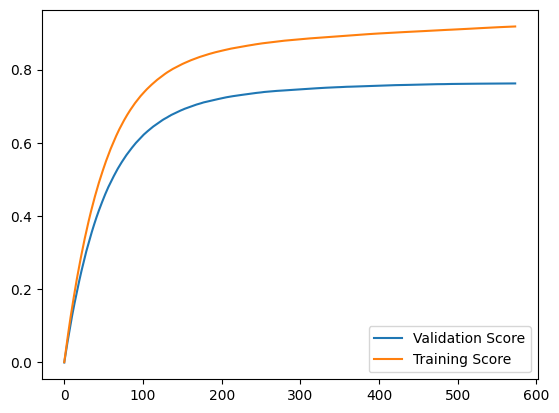

In [14]:
plt.plot(model.validation_score_, label='Validation Score')
plt.plot(model.train_score_, label='Training Score')
plt.legend()

In [15]:
# shap values
# sample 500 values from x_val
x_sample = x_val[np.random.choice(x_val.shape[0], 500, replace=False)]

explainer = shap.TreeExplainer(model, x_sample, feature_names=x_cols)
shap_values = explainer(x_sample, check_additivity=False)

 99%|===================| 497/500 [02:40<00:00]        

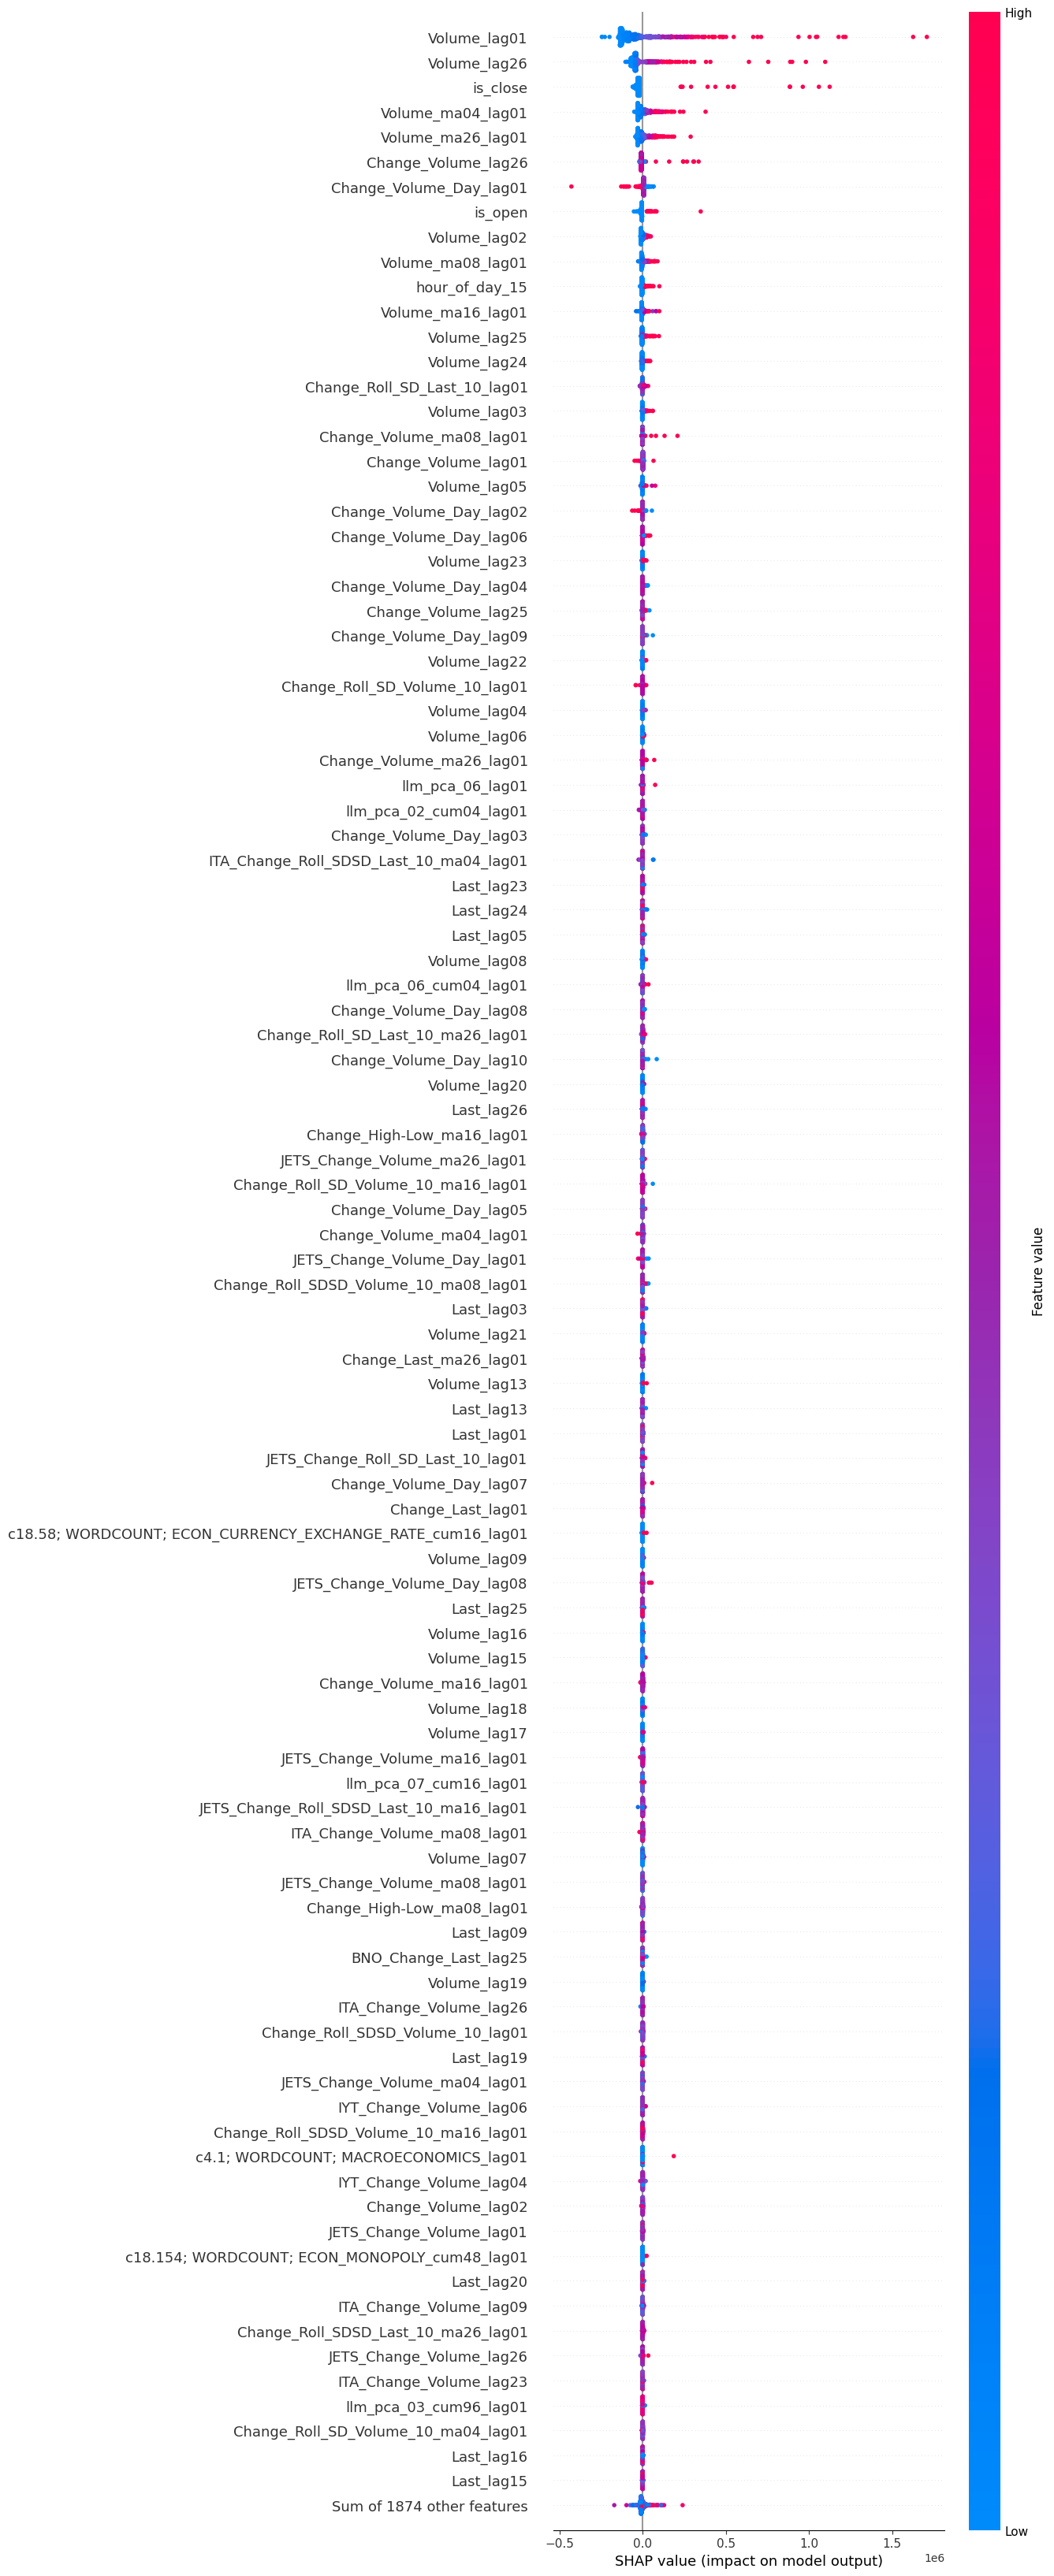

In [16]:
shap.plots.beeswarm(shap_values, max_display=100)

In [160]:
y_pred = model.predict(x_val)
plot_data = y_val.copy()
plot_data['Time'] = plot_data.index
plot_data.reset_index(drop=True, inplace=True)

In [235]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred < 0, 0, y_pred)  # Ensure no negative predictions
y_pred = pd.Series(y_pred, index=y_val.index)

In [236]:
df_results = df.copy()
df_results = df_results.iloc[y_val.index,:]
df_results['y_pred'] = y_pred
df_results['residuals'] = df_results['Volume'] - df_results['y_pred']
df_results

date ticker  Article Count_cum04_lag01  \
270085 2023-12-04 14:00:00    ALK                         18   
270086 2023-12-04 14:00:00    DAL                          2   
270087 2023-12-04 14:00:00   JBLU                          7   
270088 2023-12-04 14:00:00    LUV                          2   
270089 2023-12-04 14:00:00    UAL                          2   
...                    ...    ...                        ...   
303840 2024-08-30 13:30:00   ALGT                          0   
303841 2024-08-30 13:30:00    ALK                          2   
303842 2024-08-30 13:30:00    DAL                          1   
303843 2024-08-30 13:30:00   JBLU                          5   
303844 2024-08-30 13:30:00    LUV                          3   

        Article Count_cum16_lag01  Article Count_cum48_lag01  \
270085                         77                        173   
270086                         13                         29   
270087                         31                         79   
270088                         14                         30   
270089                         12                         33   
...                           ...                        ...   
303840                          0                          1   
303841                          6                         22   
303842                          7                         11   
303843                         16                         36   
303844                         14                         20   

        Article Count_cum96_lag01  Article Count_lag01  Article Count_lag02  \
270085                        641                    3                   10   
270086                         64                    1                    0   
270087                        415                    2                    2   
270088                         60                    1                    1   
270089                         79                    1                    0   
...                           ...                  ...                  ...   
303840                          2                    0                    0   
303841                         74                    1                    1   
303842                         50                    1                    0   
303843                         85                    2                    2   
303844                         38                    1                    2   

        Article Count_lag04  Article Count_lag16  ...  sentiment_pca_295  \
270085                    3                    5  ...           0.565441   
270086                    1                    1  ...          -0.036747   
270087                    2                    1  ...          -0.056143   
270088                    0                    1  ...           0.075383   
270089                    1                    1  ...          -0.030756   
...                     ...                  ...  ...                ...   
303840                    0                    0  ...          -0.029826   
303841                    0                    0  ...           0.032163   
303842                    0                    0  ...          -0.294496   
303843                    0                    0  ...           0.127846   
303844                    0                    0  ...          -0.066449   

        sentiment_pca_296  sentiment_pca_297  sentiment_pca_298  \
270085          -0.304639          -0.546424           0.632031   
270086           0.025630           0.284650          -0.014649   
270087           0.425695           0.169083           0.239773   
270088           0.127710           0.428332          -0.095260   
270089           0.309050           0.646624          -0.592963   
...                   ...                ...                ...   
303840           0.018689           0.026539          -0.008435   
303841          -0.034872          -0.086550           0.020872   
303842           0.

In [237]:
for i in df['ticker'].unique():
    vals = df.iloc[y_val.index,:][df['ticker'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

AAL: 0.626
ALGT: 0.458
ALK: 0.650
DAL: 0.693
JBLU: 0.587
LUV: 0.529
UAL: 0.744


In [238]:
df['time_of_day'] = df['date'].dt.time

for i in np.sort(df['time_of_day'].unique()):
    vals = df.iloc[y_val.index,:][df['time_of_day'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

09:30:00: 0.307
09:45:00: 0.655
10:00:00: 0.797
10:15:00: 0.828
10:30:00: 0.857
10:45:00: 0.724
11:00:00: 0.778
11:15:00: 0.759
11:30:00: 0.821
11:45:00: 0.739
12:00:00: 0.808
12:15:00: 0.777
12:30:00: 0.736
12:45:00: 0.417
13:00:00: 0.617
13:15:00: 0.838
13:30:00: 0.816
13:45:00: 0.730
14:00:00: 0.731
14:15:00: 0.774
14:30:00: 0.743
14:45:00: 0.816
15:00:00: 0.726
15:15:00: 0.756
15:30:00: 0.767
15:45:00: 0.767


In [195]:
df['day_of_week'] = df['date'].dt.day_of_week

for i in np.sort(df['day_of_week'].unique()):
    vals = df.iloc[y_val.index,:][df['day_of_week'] == i].index
    print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')

0: 0.733
1: 0.729
2: 0.728
3: 0.774
4: 0.761


In [200]:
df['month_of_year'] = df['date'].dt.month

for i in np.sort(df['month_of_year'].unique()):
    try:
        vals = df.iloc[y_val.index,:][df['month_of_year'] == i].index
        print(f'{i}: {r2(y_val[y_val.index.isin(vals)], y_pred[y_pred.index.isin(vals)]):.3f}')
    except Exception:
        pass

1: 0.727
2: 0.822
3: 0.745
4: 0.804
5: 0.692
6: 0.719
7: 0.754
8: 0.700
12: 0.804


In [188]:
np.sort(df['time_of_day'].unique())

array([datetime.time(9, 30), datetime.time(9, 45), datetime.time(10, 0),
       datetime.time(10, 15), datetime.time(10, 30),
       datetime.time(10, 45), datetime.time(11, 0), datetime.time(11, 15),
       datetime.time(11, 30), datetime.time(11, 45), datetime.time(12, 0),
       datetime.time(12, 15), datetime.time(12, 30),
       datetime.time(12, 45), datetime.time(13, 0), datetime.time(13, 15),
       datetime.time(13, 30), datetime.time(13, 45), datetime.time(14, 0),
       datetime.time(14, 15), datetime.time(14, 30),
       datetime.time(14, 45), datetime.time(15, 0), datetime.time(15, 15),
       datetime.time(15, 30), datetime.time(15, 45)], dtype=object)

In [137]:
plot_data = pd.merge(plot_data, pd.DataFrame(y_pred, columns=['y_pred']), left_index=True, right_index=True)

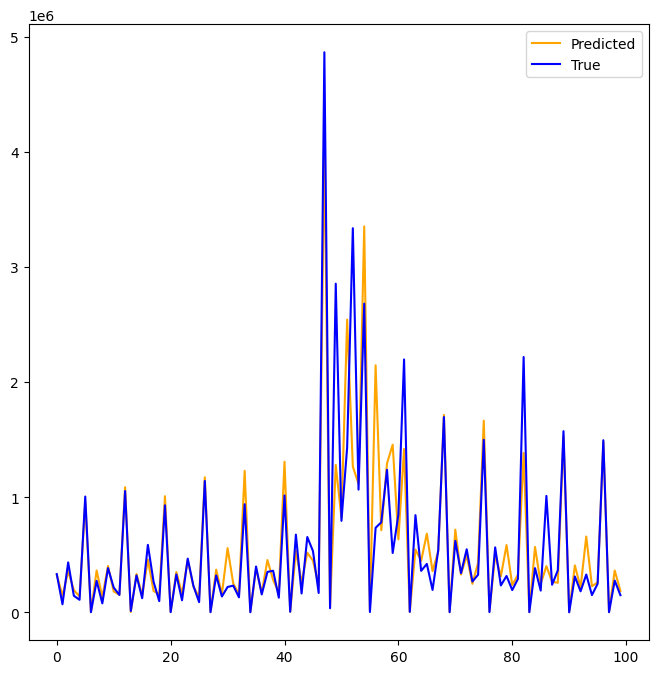

In [138]:
filter_data = plot_data.iloc[:100,:]

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['y_pred'], label='Predicted', color='orange')
plt.plot(filter_data.index, filter_data['Volume'], label='True', color='blue')
plt.legend()

C:\Users\Steven\AppData\Local\Temp\ipykernel_1220\2646763451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']


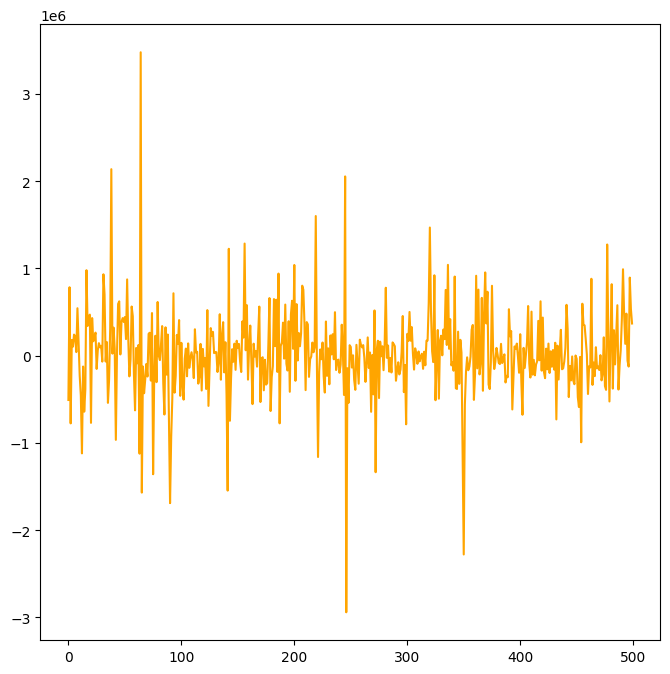

In [165]:
filter_data = plot_data.iloc[:500,:]
filter_data['residuals'] = filter_data['AAL_Volume'] - filter_data['y_pred']

plt.figure(figsize=(8, 8))
plt.plot(filter_data.index, filter_data['residuals'], label='residuals', color='orange')